<a href="https://colab.research.google.com/github/ypetkov11/portfolio/blob/main/Softuni%20AI%20Module/Deep%20Learning/ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
!pip install mlflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

import mlflow
import mlflow.tensorflow

In [ ]:
import os

from PIL import Image

from google.colab import drive

from collections import Counter
import random

import string

from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler, EarlyStopping

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Add, Dropout, Input, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def set_seed(seed: int = 42) -> None:
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  # When running on the CuDNN backend, two further options must be set
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  # Set a fixed value for the hash seed
  os.environ["PYTHONHASHSEED"] = str(seed)
  print(f"Random seed set as {seed}")

set_seed(43)

Random seed set as 43


# Image Captioning

## Introduction

Image captioning is a well-known deep learning task, used to provide a caption to an image. This is can be found useful in multiple fields, explaining X-ray scans for example. The aim of this project will be to compare different Image captioning models.

## Working with data

### Loading the data

This part is self-explanatory. In the dataset folder there is a `captions.txt`, where every image is allocated a caption on each row. The Flickr8k dataset consists of 8091 images every one of which has 5 different captions.

In [ ]:
# Paths to the downloaded files
image_folder = '/content/drive/My Drive/Colab Notebooks/Project/data/flickr/Images'
caption_file = '/content/drive/My Drive/Colab Notebooks/Project/data/flickr/captions.txt'

In [ ]:
# Function to read and parse the captions file
def load_captions(caption_file):
  with open(caption_file, 'r') as f:
    lines = f.readlines()[1:] # Skip the first row, because it reads "images, captions"

  image_captions = {}
  for line in lines:
    split_line = line.strip().split(',')
    image_id, caption = split_line[0], ','.join(split_line[1:])
    image_path = os.path.join(image_folder, image_id)

    if image_path in image_captions:
      image_captions[image_path].append(caption)
    else:
      image_captions[image_path] = [caption]

  return image_captions

# Load captions
captions = load_captions(caption_file)

In [ ]:
# Flatten the image and caption pairs
image_paths = []
all_captions = []
for image_path, caps in captions.items():
  for cap in caps:
    image_paths.append(image_path)
    all_captions.append(cap)

### Altering the captions

Now, I know preprocessing data outside of a pipeline is not desirable, but we will not be doing anything major here and there certainly will not be any data leaks.

First off, we will make all of the text lowercase and remove punctuation. Then we are going to put special start of sentence and end of sentence tokens. We are not going to remove stopwords or use stemming because we want our model to be able to generate coherent captions.

In [ ]:
# Define a translation table to remove punctuation
translator = str.maketrans('', '', string.punctuation)

processed_captions = [f'<sos> {caption.translate(translator).lower().strip()} <eos>' for caption in all_captions]

In [ ]:
processed_captions

['<sos> a child in a pink dress is climbing up a set of stairs in an entry way <eos>',
 '<sos> a girl going into a wooden building <eos>',
 '<sos> a little girl climbing into a wooden playhouse <eos>',
 '<sos> a little girl climbing the stairs to her playhouse <eos>',
 '<sos> a little girl in a pink dress going into a wooden cabin <eos>',
 '<sos> a black dog and a spotted dog are fighting <eos>',
 '<sos> a black dog and a tricolored dog playing with each other on the road <eos>',
 '<sos> a black dog and a white dog with brown spots are staring at each other in the street <eos>',
 '<sos> two dogs of different breeds looking at each other on the road <eos>',
 '<sos> two dogs on pavement moving toward each other <eos>',
 '<sos> a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl <eos>',
 '<sos> a little girl is sitting in front of a large painted rainbow <eos>',
 '<sos> a small girl in the grass plays with fingerpaints in front of a white canvas with

### Splitting the data

Since our images and captions are in order (the first five images, which is the same image, correspond to the first five captions), we can split the data using indices. This is done easily but is not perfect because this way an image can appear in two sets - the training and the validation set, for example, and validation metrics will be scored on already familiar to the model data, which is not optimal. We may afford to overlook this though because the worst case scenario we will get few biased entries in the validation set.

In [ ]:
# Generate indices and shuffle them
indices = np.arange(len(image_paths))

# Calculate split sizes
train_size = int(0.8 * len(indices))
val_size = int(0.1 * len(indices))
test_size = len(indices) - train_size - val_size

# Split the indices
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Now split your image paths and captions according to these indices
train_images, train_captions = [image_paths[i] for i in train_indices], [processed_captions[i] for i in train_indices]
val_images, val_captions = [image_paths[i] for i in val_indices], [processed_captions[i] for i in val_indices]
test_images, test_captions = [image_paths[i] for i in test_indices], [processed_captions[i] for i in test_indices]

In [ ]:
train_split_size = len(train_captions)
val_split_size = len(val_captions)
test_split_size = len(test_captions)

print(f"Size of train split: {train_split_size}")
print(f"Size of validation split: {val_split_size}")
print(f"Size of test split: {test_split_size}")

Size of train split: 32364
Size of validation split: 4045
Size of test split: 4046


Our training set(and the others as well) looks like this for now:

<sos> a child in a pink dress is climbing up a set of stairs in an entry way <eos>


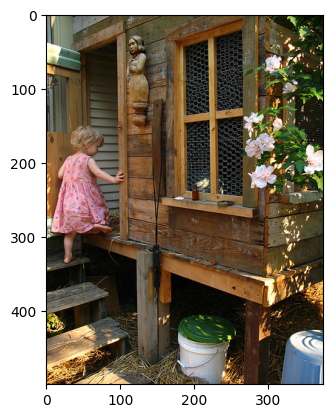

In [ ]:
plt.imshow(Image.open(train_images[0]))
print(train_captions[0])

## EDA

### Text

First of all, we may notice that not all captions are unique. This is strange, we expect to have duplicate images in `train_images` because one image is allocated multiple captions but a duplicate captions seems strange:

In [ ]:
print(len(train_captions))
print(len(set(train_captions)))

32364
32138


I think it is necessary to check, if these captions point to different images:

In [ ]:
counter = Counter(train_captions)
duplicates = {item: count for item, count in counter.items() if count > 1}

print(duplicates)  # Prints items that are duplicated and their counts

{'<sos> a black and white dog is running through the grass <eos>': 2, '<sos> a dog running through snow <eos>': 3, '<sos> the children are playing in the water <eos>': 2, '<sos> a dog runs through the snow <eos>': 3, '<sos> a dog chases another dog <eos>': 3, '<sos> two dogs are running in a field <eos>': 2, '<sos> a man is rock climbing <eos>': 2, '<sos> a dog running in a field <eos>': 2, '<sos> a dog in a field <eos>': 3, '<sos> people sit on benches <eos>': 2, '<sos> two black dogs running <eos>': 2, '<sos> a black and white dog is running in the grass <eos>': 2, '<sos> a black dog runs through a field <eos>': 2, '<sos> a dog runs in a field <eos>': 2, '<sos> a black dog runs through the water <eos>': 3, '<sos> a black dog is running in the grass <eos>': 2, '<sos> two brown dogs are running on the grass <eos>': 2, '<sos> a person skis down a snowy hill <eos>': 2, '<sos> two dogs running on grass <eos>': 3, '<sos> a man kayaks in rough water <eos>': 2, '<sos> a black dog running thr

In [ ]:
matching_keys = [key for key, value in captions.items() if 'A black and white dog is running through the grass .' in value] # Grabbed a random caption in duplicates dict

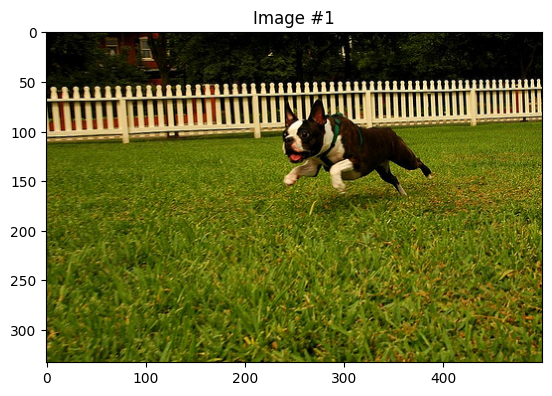

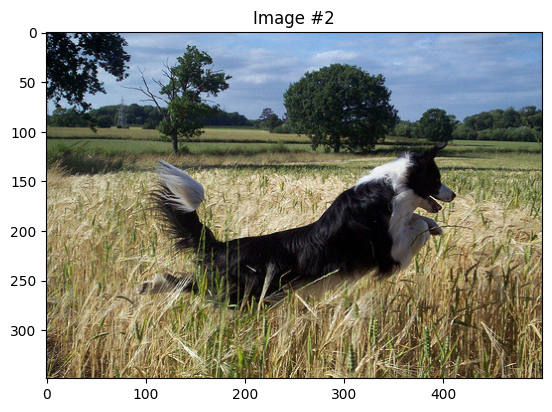

In [ ]:
for i, image in enumerate(matching_keys):
  plt.imshow(plt.imread(image))
  plt.title(f"Image #{i+1}")
  plt.show()

Ok, we may proceed.

An important part of an NLP model is its vocabulary size. For this task's purpose I will have the vocabulary size be however many words are there in the data:

In [ ]:
words = [word for caption in train_captions for word in caption.split()]

unique_words = set(words)
unique_word_count = len(unique_words)

print(f"Number of unique words: {unique_word_count}")

Number of unique words: 8037


Speaking of words, it is a good idea to check the captions for what the images depict. It will be useful to see what type of images our model will digest:

In [ ]:
dict(sorted(Counter(words).items(), key=lambda item: item[1], reverse=True))

{'a': 50236,
 '<sos>': 32364,
 '<eos>': 32364,
 'in': 15167,
 'the': 14810,
 'on': 8568,
 'is': 7546,
 'and': 7115,
 'dog': 6438,
 'with': 6130,
 'man': 5917,
 'of': 5393,
 'two': 4477,
 'white': 3198,
 'black': 3056,
 'boy': 2886,
 'are': 2808,
 'woman': 2639,
 'to': 2554,
 'girl': 2534,
 'wearing': 2435,
 'people': 2308,
 'at': 2304,
 'water': 2119,
 'young': 2082,
 'red': 2068,
 'brown': 2047,
 'his': 1925,
 'an': 1903,
 'blue': 1853,
 'running': 1754,
 'dogs': 1701,
 'through': 1657,
 'playing': 1591,
 'while': 1588,
 'down': 1483,
 'shirt': 1430,
 'ball': 1428,
 'standing': 1416,
 'little': 1367,
 'grass': 1282,
 'snow': 1246,
 'person': 1239,
 'child': 1222,
 'jumping': 1161,
 'three': 1107,
 'front': 1102,
 'over': 1095,
 'sitting': 1056,
 'holding': 1049,
 'up': 1012,
 'field': 1010,
 'by': 996,
 'one': 995,
 'group': 993,
 'large': 976,
 'small': 971,
 'yellow': 967,
 'green': 944,
 'children': 928,
 'men': 920,
 'her': 908,
 'air': 886,
 'walking': 870,
 'beach': 849,
 'into'

There seem to be a lot of dogs and people. One major flaw of the split we did earlier is that if the images we somehow ordered in the file folder, like the images of dogs are first, then come the images of people, after which are the images of airfryers and so on, our model will become biased towards dogs and people which is not desirable. Here we are relying on that there is no such ordering and the dataset itself is biased towards dogs and people (, which is still not the best scenario).

Another important part of NLP is deciding the length of the sequences we will be using. I have decided to go with the length of the longest caption in the training set as the maximum length of the sequences. We risk encountering longer captions in the other sets but keeping the dimensionality to a minimum will aid the training process.

In [ ]:
max_length_by_words = max(len(caption.split()) for caption in train_captions)

print(f"The maximum length of a caption by words is: {max_length_by_words}")

The maximum length of a caption by words is: 38


Another preparation step we are going to do now is to tokenize and get the vocabulary table from our captions, adding a token for unknown words:

In [ ]:
custom_filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer(oov_token="<unk>", filters=custom_filters)
tokenizer.fit_on_texts(train_captions)

In [ ]:
vocabulary = tokenizer.word_index

We can see our true vocabulary size now:

In [ ]:
vocab_size = len(vocabulary)

To put the chery on top, we are going to create a `tf.lookup.StaticHashTabl` that will later help us process data in our `tf.data.Dataset`

In [ ]:
keys_tensor = tf.constant(list(vocabulary.keys()))
vals_tensor = tf.constant(list(vocabulary.values()), dtype=tf.int64)
initializer = tf.lookup.KeyValueTensorInitializer(keys=keys_tensor, values=vals_tensor)
table = tf.lookup.StaticHashTable(initializer, default_value=vocabulary["<unk>"])

### Images

First we are going to iterate through a subset of the images, because opening a lot of images takes a lot of time. The amount of images we are going to use for our EDA will be enough and they will still represent the distribution of the images as a whole.

In [ ]:
set_image_paths = set(train_images)

image_heights = []
image_widths = []

reds = []
greens = []
blues = []

subset_images = set(random.sample(list(set_image_paths), 1370))

for image in subset_images:
  image = np.array(Image.open(image))

  reds.append(np.mean(image[0]))
  greens.append(np.mean(image[1]))
  blues.append(np.mean(image[2]))

  image_heights.append(image.shape[0])
  image_widths.append(image.shape[1])

Checking out the size of the images is a very important step and can dictate how we proceed with them.

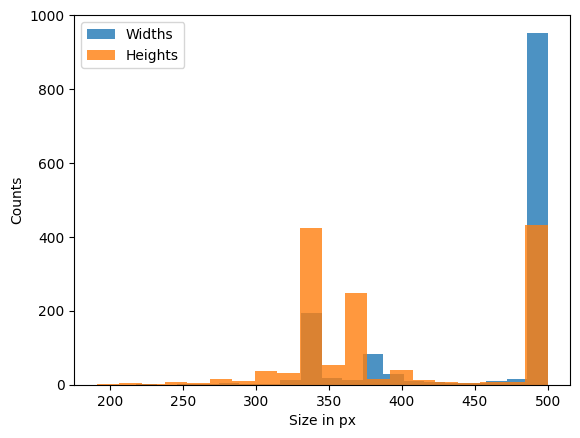

In [ ]:
plt.hist(image_widths, bins = 20, alpha=0.8, label="Widths")
plt.hist(image_heights, bins = 20, alpha=0.8, label="Heights")
plt.legend()
plt.xlabel("Size in px")
plt.ylabel("Counts")
plt.show() # oprawi gi da sa s ednakyw scale

Looks like most of the images are 500px wide and have varying height. In this situatuion using a model like InceptionV3, which takes in 299x299 images, for image feature extraction is suitable.

Finally it is good to do a routine check on the image colours and make sure they are not biased.

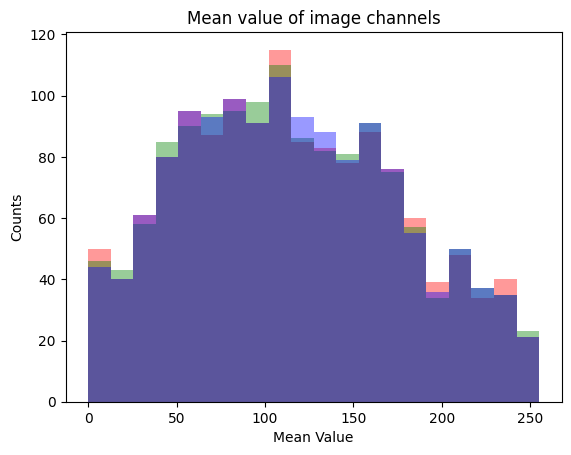

In [ ]:
plt.hist(reds, alpha = 0.4, bins=20, color="red")
plt.hist(greens, alpha = 0.4, bins=20, color="green")
plt.hist(blues, alpha = 0.4, bins=20, color="blue")
plt.ylabel("Counts")
plt.xlabel("Mean Value")
plt.title("Mean value of image channels")
plt.show()

### Creating the data pipeline

In [ ]:
# Constants used onwards

BATCH_SIZE = 3
AUTOTUNE = tf.data.AUTOTUNE
EMBEDDING_DIM = 256
VOCAB_SIZE = vocab_size
MAX_LENGTH = max_length_by_words
EPOCHS = 4
DROPOUT_RATE = 0.4

To create an efficient data pipeline we will be using `tf.data.Dataset`, we do everything as according to [this article](https://www.tensorflow.org/guide/data_performance), wihtout caching because our dataset is definitely not small and the RAM cannot handle it.

First off, we will need to preprocess images of batches and get them ready for InceptionV3 input, meaning they have to be resized and scaled a certain way. To do this we have the two functions below:

In [ ]:
# Loads and resizes images
def load_resize_images(image_paths):
  images = []
  for image_path in image_paths:
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [299, 299])
    images.append(img)
  images_tensor = tf.stack(images)
  return images_tensor

# Applies InceptionV3 scaling
def process_images(image_paths):
  images = load_resize_images(image_paths)
  processed_images = tf.keras.applications.inception_v3.preprocess_input(images)
  return processed_images

Next up is the text preprocessing. Here we have to tokenize the captions and pad the sequence so they have matching shapes:

In [ ]:
def tokenize_captions(captions):
  words = tf.strings.split(captions, ' ').to_tensor()
  tokenized_captions = table.lookup(words)
  return tokenized_captions

def process_captions(captions):
  tokenized_captions = tokenize_captions(captions)
  caps = pad_sequences(tokenized_captions, maxlen=max_length_by_words, padding='post', truncating='post')
  return caps

Finally we need to put it all together and create a mapping function so that the data is appropriate for our model. The image captioning model has two inputs - an image and a sequence, and the label is the next token in the sequence. For that purpose we will be using this map function:

In [ ]:
def map_load_data(img_paths, captions):
  X1 = []
  X2 = []
  y = []
  images = process_images(img_paths)
  captions = process_captions(captions)

  n=0
  for image in images:
    for i in range(1, MAX_LENGTH):
      caption = captions[n]
      in_seq, out_seq = caption[:i], caption[i]
      X1.append(image)
      X2.append(*pad_sequences([in_seq], maxlen=MAX_LENGTH, padding="post", truncating="post"))
      y.append(out_seq)
    n+=1

  return X1, X2, y

Notice how `BATCH_SIZE` is set to pretty low number, that is because it indicates how many image-caption pairs will be included in the batch, from each pair there will be 37 entries of data (because of the partial way we will be giving the captions to the model). This will result in big batch sizes even for small values in `BATCH_SIZE`.

Now we can derive a function that returns a dataset ready for fitting:

In [ ]:
def prepare_dataset(dataset, buffer_size):
  dataset = dataset.shuffle(buffer_size) \
                   .batch(BATCH_SIZE) \
                   .map(lambda img_path, cap: tf.py_function(
                       map_load_data, [img_path, cap], [tf.float32, tf.int32, tf.int32]),
                       num_parallel_calls=AUTOTUNE) \
                   .map(lambda x1, x2, y: ((x1, x2), y)) \
                   .prefetch(AUTOTUNE)

  dataset = dataset.map(lambda x, y: ((tf.ensure_shape(x[0], (None, 299, 299, 3)), tf.ensure_shape(x[1], (None, MAX_LENGTH))), tf.ensure_shape(y, (None,))))
  return dataset

All that is left now is create the datasets:

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_captions))
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_captions))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_captions))

In [ ]:
train_ds = prepare_dataset(train_ds, train_split_size)
val_ds = prepare_dataset(val_ds, val_split_size)
test_ds = prepare_dataset(test_ds, test_split_size)

## Creating the model

### Base architecture

The model consists of two parts an encoder and a decoder. The decoder has two inputs - the image and the sequence so far, from which it has to extract features. The role of the decoder is to predict the next token based on those features.

- Encoder
  - Image feature extractor
    - Inception model
    - Global Average Pooling layer (so it in a way flattens the inception output)
    - Dropout layer (as a form of regularization)
    - Dense layer
  - Sequence feature extractor
    - Embedding
    - Dropout layer (as a form of regularization)
    - LSTM
- Decoder
  - Add layer (element-wise addition on both of the feature extractors' outputs)
  - Dense layer
  - Dense layer (for classification)

Here is how our model is defined:

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
inception = InceptionV3(weights='imagenet', include_top=False)
inception.trainable = False # setting InceptionV3 model as non-trainable

# Encoder
# image features
image_input = Input(shape=(299,299,3))
x = inception(image_input)
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(256, activation="relu")(x)

# sequence features
sequence_input = Input(shape=(MAX_LENGTH,))
y = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, mask_zero=True)(sequence_input) # mask_zero will help deal with the padding
y = Dropout(DROPOUT_RATE)(y)
y = LSTM(256)(y)

#Decoder
decoder = Add()([x, y])
decoder = Dense(256, activation="relu")(decoder)
output = Dense(VOCAB_SIZE, activation="softmax")(decoder)

captioning_lstm = Model(inputs=[image_input, sequence_input], outputs=output)

In [ ]:
captioning_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 inception_v3 (Functional)   (None, None, None, 2048)     2180278   ['input_2[0][0]']             
                                                          4                                       
                                                                                                  
 input_3 (InputLayer)        [(None, 38)]                 0         []                            
                                                                                                  
 global_average_pooling2d (  (None, 2048)                 0         ['inception_v3[0][0]']    

Here's what it looks like:

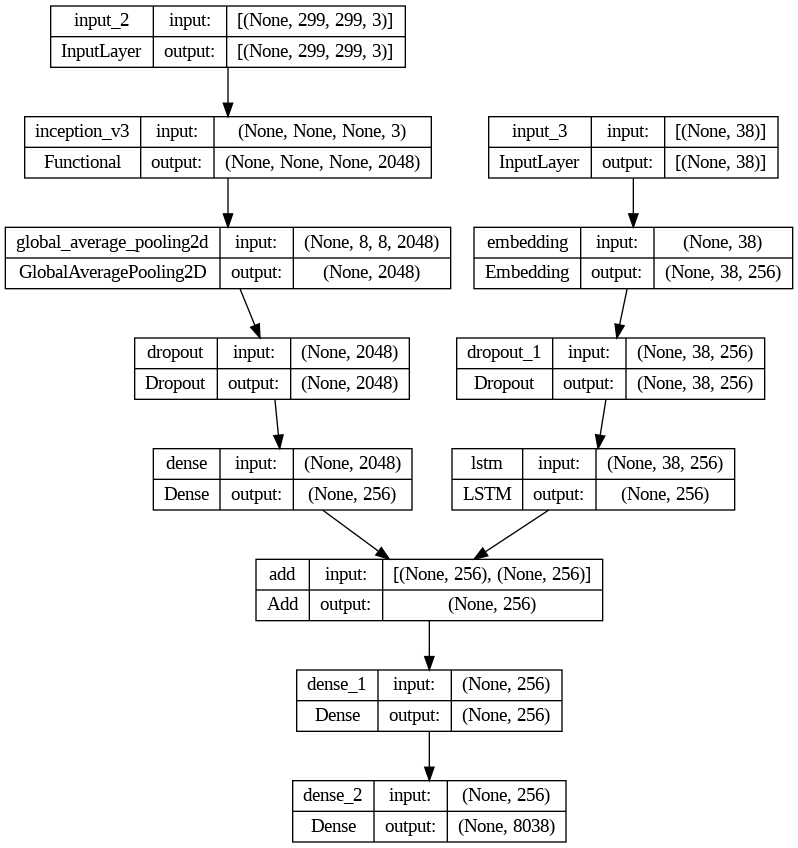

In [ ]:
tf.keras.utils.plot_model(captioning_lstm, show_shapes=True)

### Setting the optimizer and the loss function

The loss function is sparse categorical crossentropy since we are doing classification on non-one-hot encoded labels. For the optimizer we will be using Adam, because it is good at handling sparse gradients.

Additionally, we will encorporate a learning rate scheduler for traversing the gradient more efficiently:

In [ ]:
initial_learning_rate = 0.00001
decay_steps = 8000
decay_rate = 0.93

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
captioning_lstm.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

## Training the model

### Setting up callbacks

**A quick disclaimer**, since the number of batches in an epoch is enormous, we will not be training the model on loads of batches, which will hinder the effectivenes of some callbacks. For instance applying ``EarlyStopping()`` might usually be useful and save a lot of time but, since it triggers on an epoch`s end, we will not be utilizing it now. **Disclaimer over**

First we will use checkpoints to save the states of our model during training. That way we can return the model to its previous state if it starts overfitting on the training set (again though only at an epoch`s end):

In [ ]:
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/Project/checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=True,
                                                 monitor='val_loss',
                                                 mode='min')

Next we are going to set a callback for logging training data in tensorboard:

In [ ]:
tensorboard_callback = TensorBoard(log_dir='/content/drive/My Drive/Colab Notebooks/Project/logs', histogram_freq=1, write_graph=True, write_images=True, update_freq=2000)

This is what our callbacks array looks like:

In [ ]:
callbacks = [tensorboard_callback, cp_callback]

## Training the model

This part is self-explanatory. To log the training process we will use MLflow:

In [ ]:
mlflow.end_run()

In [ ]:
mlflow.start_run()
params = {
  "batch_size": BATCH_SIZE * 37, # because of the sequences
  "epochs": EPOCHS,
  "dropout_rate": DROPOUT_RATE,
}
mlflow.log_params(params)

# Train the model with the custom callback to log metrics
history = captioning_lstm.fit(
    train_ds,
    epochs=params["epochs"],
    validation_data=val_ds,
    callbacks=callbacks
)

captioning_lstm.save('/content/drive/My Drive/Colab Notebooks/Project/captioning_lstm.h5')

# Log the final metrics
final_metrics = {
    "final_loss": history.history['loss'][-1],
    "final_val_loss": history.history['val_loss'][-1],
}
mlflow.log_metrics(final_metrics)

# Log the TensorFlow model to MLflow
mlflow.keras.log_model(captioning_lstm, "model")

mlflow.end_run()

Epoch 1/4
 3746/10788 [=========>....................] - ETA: 1:41:10 - loss: 2.8400 - accuracy: 0.5968

**Disclaimer** Due to using google colab for so long I cannot get a gpu session in which I can train the model. I literally got a session for an hour and then it got suspended while training the model (it is not from inactivity). It is a shame you have to pay for Google Colab Pro to avoid these situations

### Training results

If the session hadn't been suspended, we would have been able to plot the loss function now and asses our model's performance by plotting the loss and the validation loss, checking if the model generelizes well. But even if nothing had gone wrong the plot would have been very choppy because of the small amount of epochs, so training for more epochs is recommended (not just to get a better plot):

In [ ]:
loss_values = history.history['loss']
val_loss_values = history.history.get('val_loss')

epochs = range(1, len(loss_values) + 1)

plt.figure()
plt.plot(epochs, loss_values, color="blue", label='Training loss')
plt.plot(epochs, val_loss_values, color="orange", label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Let's try to see what's on the tensorboard logs:

In [ ]:
%load_ext tensorboard

In [ ]:
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir "/content/drive/My Drive/Colab Notebooks/Project/logs"

<IPython.core.display.Javascript object>

### Testing the model

OK, despite the issues with Google Colab, I have a checkpoints from the draft for this project (I cannot guarantee the outcome is desirable). I will try and salvage what's possible.

In [ ]:
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/Project/checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_path)

captioning_lstm.load_weights(latest)

Let's see how this model predicts captions, shall we:

In [ ]:
# Function to generate a caption for an image from the test set
def generate_caption(image_path):
  image = process_images([image_path])
  image = tf.convert_to_tensor(image)
  output_seq = ["<sos>"]
  while len(output_seq) <= MAX_LENGTH:
    processed_seq = process_captions([' '.join(output_seq)])
    predictions = captioning_lstm.predict([image, processed_seq])
    next_token = np.argmax(predictions, axis=-1)[0]
    output_seq.append(tokenizer.index_word[next_token])
    if next_token == vocabulary["<eos>"]:
      break
  return ' '.join(output_seq)

In [ ]:
def show_results(image_index):
  plt.imshow(plt.imread(test_images[image_index]))
  plt.show()
  predicted_caption = generate_caption(test_images[image_index])
  print(f'Real caption: {test_captions[image_index]}')
  print(f'Predicted caption: {predicted_caption}')

In [ ]:
random_indices = [0, 194, 2534, 58, 93, 3001, 1735] # I have picked just random indices

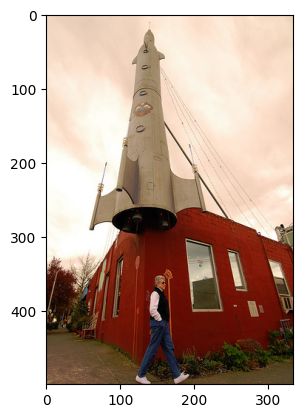

1/1 [==============================] - 0s 231ms/step
Real caption: <sos> a person walking by a red building with a jet on top of it <eos>
Predicted caption: <sos> a man in a white dog in a water <eos>


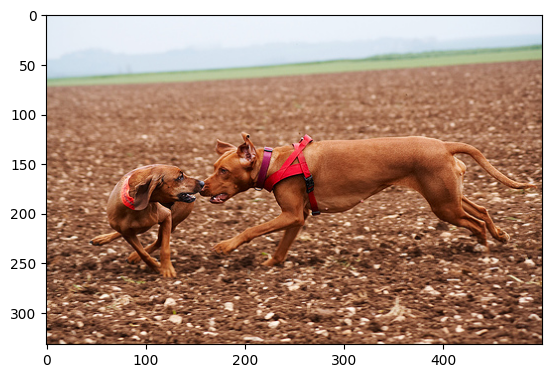

1/1 [==============================] - 0s 204ms/step
Real caption: <sos> two dogs play together <eos>
Predicted caption: <sos> a dog is running in the grass <eos>


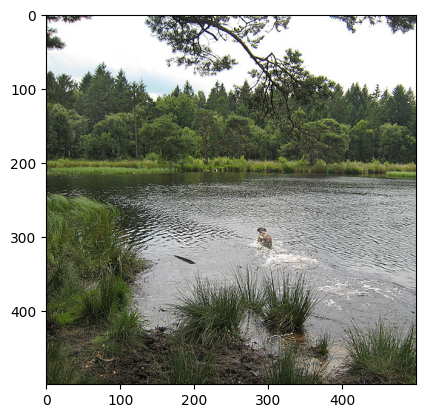

1/1 [==============================] - 0s 168ms/step
Real caption: <sos> an animal is attempting to cross the river <eos>
Predicted caption: <sos> a dog is a dog in a water <eos>


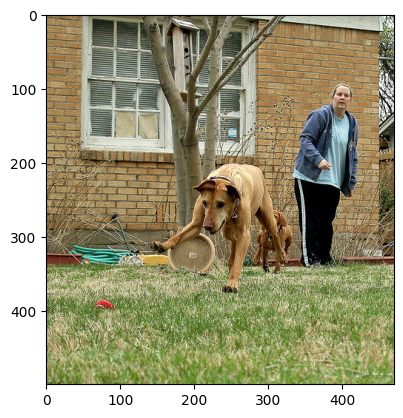

1/1 [==============================] - 0s 170ms/step
Real caption: <sos> a woman in a blue jacket watches as her two brown dogs play with a red ball in a grassy yard <eos>
Predicted caption: <sos> a dog is in a dog <eos>


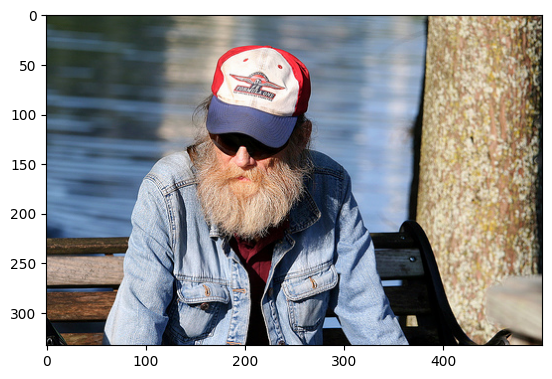

1/1 [==============================] - 0s 173ms/step
Real caption: <sos> a man with a bushy beard and a baseball cap sits on a park bench <eos>
Predicted caption: <sos> a man in a man in a man <eos>


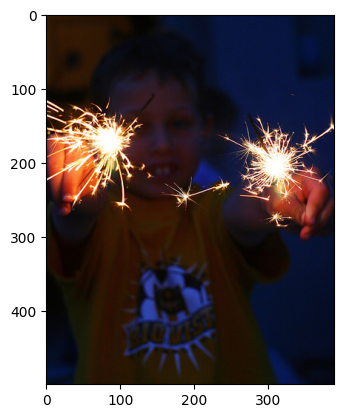

1/1 [==============================] - 0s 165ms/step
Real caption: <sos> a boy holds two sparklers <eos>
Predicted caption: <sos> a man in a white dog in a white and white and white dog in a white <eos>


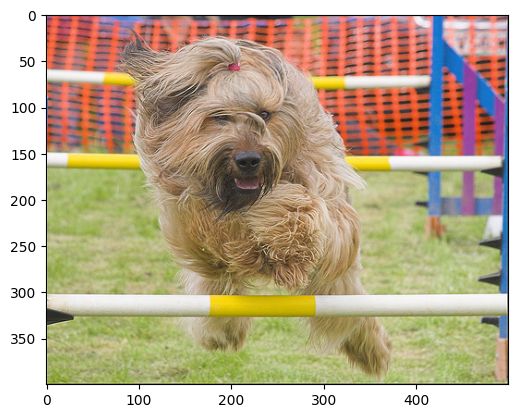

1/1 [==============================] - 0s 177ms/step
Real caption: <sos> the dog is jumping over a yellow and white fence on an obstacle course <eos>
Predicted caption: <sos> a dog is in a white dog in a grass <eos>


In [ ]:
for index in random_indices:
  show_results(index)

As you can see this state of the model very rarely makes sense. There are some outputs that are somewhat acceptable but it has very much overfitted on some words like "man", "dog" and "water".

## Future development

To train and assess other more complex image captioning model structures like visual attention and transformers (which are currently considered state of the art), on the testing set. Also more insight into explainability is needed.

## Sources and references

- [Dataset](https://www.kaggle.com/datasets/adityajn105/flickr8k)
- [Pritish Mishra (1)](https://colab.research.google.com/drive1EYUxzhBF5Tr5GxY7QxOGopuwacniMhS1)
- [Pritish Mishra (2)](https://www.youtube.com/watch?v=aaP7JJZuvGs)
- [aswintechguy](https://github.com/aswintechguy/Deep-Learning-Projects/commits?author=aswintechguy)